In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
year = "2021"

rtn = pd.read_pickle("Data/allstock_reduced.pickle").abs().pct_change(fill_method=None).loc[year]
mask = pd.read_pickle("Data/spx_mask.pickle").loc[year].iloc[-1] # 마지막 날만 가져온다

In [28]:
# 2022년 마지막날의 S&P500 구성 종목을 가져오기 위해서 기업의 리스트를 뽑는다
col = mask.dropna().index
len(col)

505

In [29]:
# S&P500 구성종목만 가져온다 (1년간 주가가 전부 있는 주식)
sp500 = rtn.loc[:,col].dropna(axis=1)
len(sp500.columns)

504

In [30]:
# corr_matrix 계산
cor_matrix = sp500.corr()
cor_matrix

PERMNO,14702,50876,60442,19502,59176,43350,64995,66181,66157,61735,...,88281,18312,75694,17700,15850,63467,13210,83597,15272,90090
PERMNO,,,,,,,,,,,,,,,,,,,,,
14702,1.000000,0.165000,0.280997,0.162490,0.300411,0.291537,0.283420,0.261844,0.195830,0.142459,...,0.357525,0.134597,0.442870,0.415111,0.387913,0.284719,0.415793,0.219690,0.467507,0.328525
50876,0.165000,1.000000,0.064066,0.122281,0.046084,0.098848,0.071675,0.120755,0.020745,0.061112,...,0.204251,0.125929,0.051943,-0.025061,0.037850,0.043163,0.134656,0.032264,0.010847,0.009041
60442,0.280997,0.064066,1.000000,0.272154,0.675121,0.490083,0.885863,0.256809,0.842928,0.297458,...,0.123320,-0.093065,0.125460,0.120301,0.137093,0.426860,0.036318,0.149605,0.195448,0.597891
19502,0.162490,0.122281,0.272154,1.000000,0.179491,0.302542,0.322490,0.205717,0.249713,0.152013,...,0.012105,0.036860,0.046487,-0.024076,0.076996,0.156988,0.033223,0.050988,0.058873,0.276490
59176,0.300411,0.046084,0.675121,0.179491,1.000000,0.499404,0.682297,0.204694,0.624066,0.297508,...,0.240176,-0.238091,0.232322,0.179941,0.227878,0.494461,0.171209,0.106780,0.152019,0.518884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63467,0.284719,0.043163,0.426860,0.156988,0.494461,0.474728,0.414634,0.391206,0.433441,0.548540,...,0.366718,-0.070337,0.326579,0.335784,0.205684,1.000000,0.290874,0.340079,0.123528,0.292884
13210,0.415793,0.134656,0.036318,0.033223,0.171209,0.314351,0.015173,0.233522,-0.028556,0.200541,...,0.428001,0.113867,0.436377,0.493090,0.297098,0.290874,1.000000,0.262136,0.322837,0.193227
83597,0.219690,0.032264,0.149605,0.050988,0.106780,0.236097,0.099527,0.262513,0.059396,0.195786,...,0.257876,0.029250,0.238983,0.316874,0.117980,0.340079,0.262136,1.000000,0.174656,-0.013786


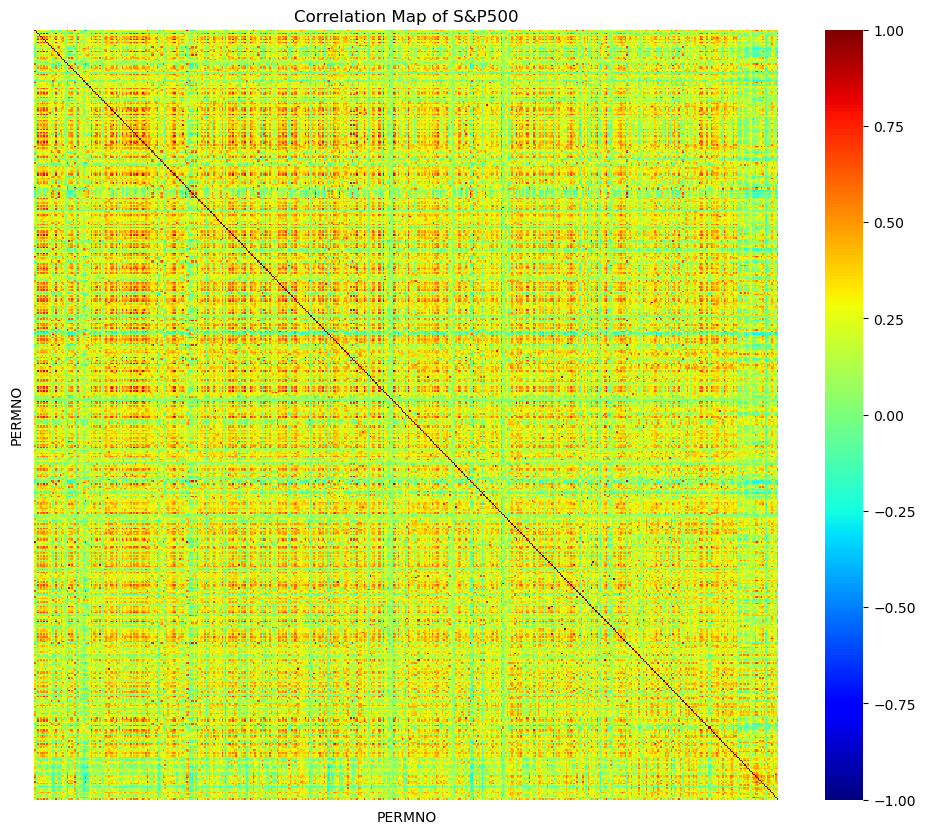

In [31]:
plt.figure(figsize=(12,10))
sns.heatmap(cor_matrix, 
            vmin=-1,
            vmax=1,
            cmap='jet', 
            xticklabels=False,
            yticklabels=False)

plt.title("Correlation Map of S&P500");

Clustering 해서 Corr Map도 뽑아보자

In [32]:
# Paper대로 T,N, 람다_+ 구현
t = len(sp500.index)
n = len(sp500.columns)
q = n/t 

lambda_plus = 1 + 2*(np.sqrt(q)) + q

In [33]:
# Cluster의 개수를 구하기(RMT 이론에 의해)
eigen_values = np.linalg.eigvalsh(cor_matrix)
k = (eigen_values > lambda_plus).sum()

In [34]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=k, 
               n_init=200,
               max_iter=1000)
kmean.fit(sp500.T)
label = kmean.labels_ #라벨의 순서는 cov_matrix의 (idx,col)순서와 동일하다

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


In [35]:
# within corr 구하기
within_corr_dict = {}

for i in range(k): # i는 클러스터를 의미
    mask = (label == i)
    card_cluster = mask.sum()
    cluster_corr = sp500.loc[:,mask].corr().values
    
    with_in_cluster = (cluster_corr - np.diag(np.diag(cluster_corr))).sum() / (card_cluster * (card_cluster-1))
    if np.isnan(with_in_cluster) == True:
        with_in_cluster = 0
    within_corr_dict[i] = with_in_cluster 

C:\Users\user\AppData\Local\Temp\ipykernel_21172\3857817749.py:9: RuntimeWarning: invalid value encountered in double_scalars
  with_in_cluster = (cluster_corr - np.diag(np.diag(cluster_corr))).sum() / (card_cluster * (card_cluster-1))


In [36]:
within_corr_dict

{0: 0.22767928707388388,
 1: 0,
 2: 0.7469425110136034,
 3: 0.43195408709875305,
 4: 0.5961540952946428,
 5: 0.3511270705191321,
 6: 0,
 7: 0.6541723274423719,
 8: 0.5325983789331499}

In [37]:
# between corr은 pair로 나와야함
between_corr_dict = {}

for i in range(k): # i는 클러스터를 의미
    mask_i = (label == i)
    card_i = mask_i.sum()
    stock_i = sp500.loc[:, mask_i]
    
    for j in range(k): # 클러스터 j를 뽑고
        if i == j:
            continue
        mask_j = (label == j)
        card_j = mask_j.sum()
        stock_j = sp500.loc[:, mask_j]
        
        all_corr = sp500.loc[:, mask_i+mask_j].corr().values
        all_corr_sum = (np.triu(all_corr) - np.diag(np.diag(all_corr))).sum()
        
        inner_corr_i = sp500.loc[:, mask_i].corr().values
        all_corr_sum_i = (np.triu(inner_corr_i) - np.diag(np.diag(inner_corr_i))).sum()        
        
        inner_corr_j = sp500.loc[:, mask_j].corr().values
        all_corr_sum_j = (np.triu(inner_corr_j) - np.diag(np.diag(inner_corr_j))).sum()   
        
        final_corr = all_corr_sum - all_corr_sum_i - all_corr_sum_j    
        
        between_cluster = final_corr / (2* card_i * card_j)
        between_corr_dict[(i,j)] = between_cluster

In [38]:
between_corr_dict

{(0, 1): 0.005140457198388529,
 (0, 2): 0.02124592628716691,
 (0, 3): 0.05363821523406973,
 (0, 4): 0.02952653207043141,
 (0, 5): 0.10042645091762119,
 (0, 6): 0.0038207474800340696,
 (0, 7): 0.02570140199860209,
 (0, 8): 0.0659000167647922,
 (1, 0): 0.005140457198388529,
 (1, 2): -0.00635946581974,
 (1, 3): 0.0019052542880984478,
 (1, 4): 0.008678680132231312,
 (1, 5): -0.001717002338702849,
 (1, 6): 0.003529888694247293,
 (1, 7): -0.0008743258540307278,
 (1, 8): 0.005003741256506047,
 (2, 0): 0.021245926287166955,
 (2, 1): -0.00635946581974,
 (2, 3): 0.05268836509017069,
 (2, 4): 0.08510192774943792,
 (2, 5): 0.12595761345379808,
 (2, 6): 0.016377848689181046,
 (2, 7): 0.20806757709803067,
 (2, 8): 0.23821417160917868,
 (3, 0): 0.05363821523406974,
 (3, 1): 0.0019052542880984478,
 (3, 2): 0.05268836509017069,
 (3, 4): -0.015340544575028732,
 (3, 5): 0.11035881789451688,
 (3, 6): 0.10433644355984102,
 (3, 7): 0.09557382062422279,
 (3, 8): 0.08084422441454538,
 (4, 0): 0.02952653207043

In [39]:
# Within Correlation으로 S를 (i,j) 원소에 채우기... (i,j는 하나의 클러스터에 포함됨...)
cor_matrix_cluster = pd.DataFrame(index=cor_matrix.index,
                                  columns=cor_matrix.columns)

for i in range(k): # i는 각 클러스터를 의미함
    mask = (label == i)
    within_corr = within_corr_dict[i] # 이 within_corr을 각 회사의 pair 자리에 채워야함
    
    # select the rows and columns corresponding to the True values
    selected_rows = cor_matrix_cluster.loc[mask, :]
    selected_cols = cor_matrix_cluster.loc[:, mask]
    # fill in the selected values with a specific value 
    selected_rows.loc[:, selected_cols.columns] = within_corr
    selected_cols.loc[selected_rows.index, :] = within_corr
    # update the original correlation matrix with the modified values
    cor_matrix_cluster.loc[mask, :] = selected_rows
    cor_matrix_cluster.loc[:, mask] = selected_cols

np.fill_diagonal(cor_matrix_cluster.values, 1) # 대각 행렬에 1을 채운다

C:\Users\user\AppData\Local\Temp\ipykernel_21172\1806642392.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows.loc[:, selected_cols.columns] = within_corr
C:\Users\user\AppData\Local\Temp\ipykernel_21172\1806642392.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_cols.loc[selected_rows.index, :] = within_corr


In [40]:
# Between corr으로 각 위치에 값을 채우기: 각 클러스터 p,q에서 pair에서 주식을 뽑고
## 주식 i, j자리에 행렬을 between corr으로 채운다

for (p,q), between_corr in between_corr_dict.items(): # p,q는 클러스터를 의미함
    mask_p = (label == p)
    mask_q = (label == q)
    
    for i,bol_i in enumerate(mask_p): # i,j는 각각 클러스터에서 기업의 bol값을 의미함
        if bol_i:
            for j, bol_j in enumerate(mask_q):
                if bol_j:
                    cor_matrix_cluster.iloc[i,j] = between_corr

In [41]:
alpha = 0.5

r = alpha * cor_matrix_cluster + (1-alpha) * cor_matrix
r

PERMNO,14702,50876,60442,19502,59176,43350,64995,66181,66157,61735,...,88281,18312,75694,17700,15850,63467,13210,83597,15272,90090
PERMNO,,,,,,,,,,,,,,,,,,,,,
14702,1.0,0.109319,0.180921,0.108064,0.190628,0.200948,0.182132,0.186102,0.138337,0.126409,...,0.394739,0.283275,0.437412,0.423532,0.409934,0.197539,0.423874,0.136664,0.44973,0.204684
50876,0.109319,1.0,0.064983,0.17498,0.055992,0.099637,0.068787,0.110591,0.043322,0.080769,...,0.128945,0.089783,0.052791,0.014288,0.045744,0.071795,0.094147,0.129972,0.032242,0.037471
60442,0.180921,0.064983,1.0,0.169027,0.60386,0.334569,0.709231,0.217931,0.687763,0.238256,...,0.102082,-0.00611,0.103152,0.100572,0.108969,0.302957,0.058581,0.107752,0.138146,0.565245
19502,0.108064,0.17498,0.169027,1.0,0.122696,0.201484,0.194195,0.153072,0.157806,0.12622,...,0.032872,0.045249,0.050063,0.014781,0.065317,0.128707,0.04343,0.139334,0.056256,0.171195
59176,0.190628,0.055992,0.60386,0.122696,1.0,0.339229,0.607448,0.191874,0.578332,0.238281,...,0.16051,-0.078623,0.156583,0.130393,0.154361,0.336758,0.126027,0.08634,0.116431,0.525741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63467,0.197539,0.071795,0.302957,0.128707,0.336758,0.412928,0.296844,0.371167,0.306248,0.449833,...,0.238538,0.020011,0.218469,0.223071,0.158021,1.0,0.200616,0.220253,0.116944,0.235969
13210,0.423874,0.094147,0.058581,0.04343,0.126027,0.212355,0.048008,0.17194,0.026144,0.15545,...,0.429978,0.272911,0.434165,0.462522,0.364526,0.200616,1.0,0.157887,0.377396,0.137036
83597,0.136664,0.129972,0.107752,0.139334,0.08634,0.168262,0.082713,0.18147,0.062648,0.148106,...,0.155757,0.041444,0.146311,0.185256,0.085809,0.220253,0.157887,1.0,0.114147,0.026057


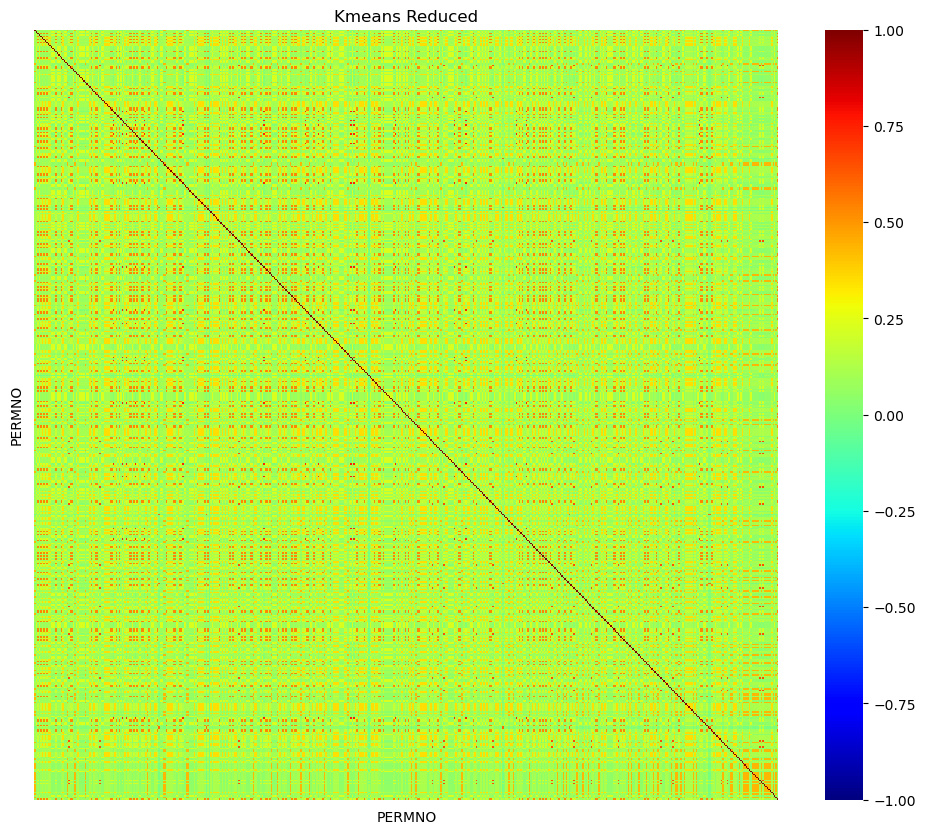

In [42]:
plt.figure(figsize=(12,10))
sns.heatmap(cor_matrix_cluster.astype("float64"), 
            vmin=-1,
            vmax=1,
            cmap='jet', 
            xticklabels=False,
            yticklabels=False)

plt.title("Kmeans Reduced");